## Multi Head Attention

In [13]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4
batch_size = 2
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [3]:
x.size()

torch.Size([2, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([2, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

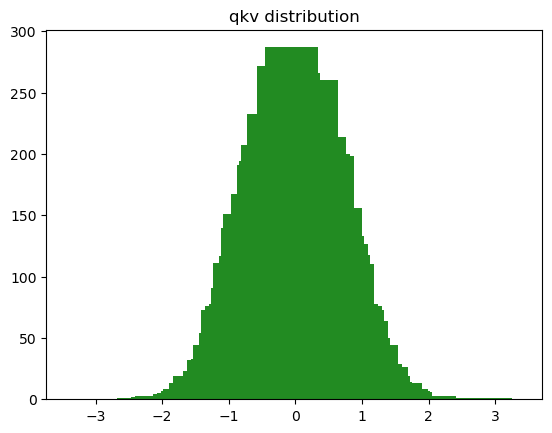

In [14]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [8]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [9]:
qkv.shape

torch.Size([2, 4, 8, 192])

In [10]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([2, 8, 4, 192])

In [11]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([2, 8, 4, 64]),
 torch.Size([2, 8, 4, 64]),
 torch.Size([2, 8, 4, 64]))

## Self Attention for multiple heads

For a single head:
$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$ 

In [15]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([2, 8, 4, 4])

In [16]:
k.T.shape

/tmp/ipykernel_2678719/3717780648.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  k.T.shape


torch.Size([64, 4, 8, 2])

In [17]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[-0.5140,  1.2559],
        [-0.9258, -0.2970],
        [ 0.3331, -0.1933]])

In [18]:
torch.transpose(y, 1, 0)

tensor([[-0.5140,  1.2559],
        [-0.9258, -0.2970],
        [ 0.3331, -0.1933]])

In [55]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [19]:
k.transpose(-1, -2).shape

torch.Size([2, 8, 64, 4])

In [20]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [21]:
(scaled + mask)[0][0]

tensor([[ 0.2953,    -inf,    -inf,    -inf],
        [ 0.4603,  0.2465,    -inf,    -inf],
        [-0.1082, -0.6708,  0.4494,    -inf],
        [ 0.1472,  0.0280, -0.4756, -0.1948]], grad_fn=<SelectBackward0>)

In [22]:
scaled += mask

In [23]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [24]:
attention = F.softmax(scaled, dim=-1)

In [25]:
attention.shape

torch.Size([2, 8, 4, 4])

In [26]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5532, 0.4468, 0.0000, 0.0000],
        [0.3015, 0.1718, 0.5267, 0.0000],
        [0.3190, 0.2832, 0.1712, 0.2266]], grad_fn=<SelectBackward0>)

In [27]:
values = torch.matmul(attention, v)
values.shape

torch.Size([2, 8, 4, 64])

## Function

In [78]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [79]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [80]:
attention.shape

torch.Size([1, 8, 4, 4])

In [81]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6270, 0.3730, 0.0000, 0.0000],
        [0.3198, 0.2655, 0.4147, 0.0000],
        [0.1996, 0.3467, 0.1564, 0.2973]], grad_fn=<SelectBackward0>)

In [70]:
values.size()

torch.Size([1, 8, 4, 64])

In [71]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [72]:
linear_layer = nn.Linear(d_model, d_model)

In [73]:
out = linear_layer(values)

In [74]:
out.shape

torch.Size([1, 4, 512])

In [75]:
out

tensor([[[ 0.0687,  0.0984,  0.0381,  ...,  0.1252,  0.0707, -0.0547],
         [-0.0399,  0.0419, -0.0933,  ...,  0.3064,  0.1585,  0.0599],
         [-0.0684, -0.0657,  0.2306,  ...,  0.0606,  0.0670,  0.0293],
         [ 0.0781, -0.0159, -0.0343,  ...,  0.0074, -0.1094, -0.0365]]],
       grad_fn=<ViewBackward0>)

## Class

In [30]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


## Input

In [31]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
